In [87]:
import numpy as np
import sklearn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary

from tslearn.datasets import UCR_UEA_datasets
import matplotlib.pyplot as plt

In [160]:
# Implement methods required by DataLoader
class UCRDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label


# Define the CNN Model
class BasicCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)  # 1 input channel (grayscale), 32 output channels
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)  # Reduce size by half
        self.fc1 = nn.Linear(64 * 71, 128)  
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

# Training Loop
def train(model, loader, criterion, optimizer, device, num_epochs = 20):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(loader):.4f}")


# Test Function
def test(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")


# Classification Function
def classify(model, sample, device):
    model.eval()
    with torch.no_grad():
        image = torch.from_numpy(sample[0]).to(device).unsqueeze(0)  # Add batch dimension
        output = model(image)

        predicted = np.zeros(len(sample[1]))
        _, ind = torch.max(output, 1)
        predicted[ind] = 1.0
    return predicted


# Plot single Time Series with Label
def plot_ts(ts_sample):
    ts, label = ts_sample
    plt.figure(figsize=(10, 4))
    plt.plot(ts[0], label="Time Series", color='blue')
    plt.title(f"Time Series Plot (Class Label: {label})")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")

    # Display grid and legend
    plt.grid(False)
    # plt.legend()
    plt.show()


# Plot all Time Series
def plot_all_ts(test_dataset):
    plt.figure(figsize=(10, 4))
    for item in test_dataset:
        ts, label = item
        color = 'blue' if label[0] == 1 else 'orange'
        plt.plot(ts[0], label="Time Series", color=color)
    plt.title(f"All Time Series")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")

    # Display grid and legend
    plt.grid(False)
    # plt.legend()
    plt.show()

In [76]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BasicCNN(num_classes=2).to(device)

In [77]:
summary(model, (1, 286))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 286]             128
         MaxPool1d-2              [-1, 32, 143]               0
            Conv1d-3              [-1, 64, 143]           6,208
         MaxPool1d-4               [-1, 64, 71]               0
            Linear-5                  [-1, 128]         581,760
            Linear-6                    [-1, 2]             258
Total params: 588,354
Trainable params: 588,354
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 2.24
Estimated Total Size (MB): 2.46
----------------------------------------------------------------


In [38]:
train_loader.dataset.feature.shape

(28, 1, 286)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 5

# Data Preparation (using MNIST as an example)

train_x, train_y, test_x, test_y=UCR_UEA_datasets().load_dataset("Coffee")
train_x = train_x.reshape(-1, 1, train_x.shape[-2])
test_x = test_x.reshape(-1, 1, test_x.shape[-2])

enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))

train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))

train_dataset = UCRDataset(train_x.astype(np.float32),train_y.astype(np.float32))
test_dataset = UCRDataset(test_x.astype(np.float32),test_y.astype(np.float32))

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Initialize the model, loss function, and optimizer
model = BasicCNN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training
train(model, train_loader, criterion, optimizer, device)

Epoch [1/20], Loss: 0.7458
Epoch [2/20], Loss: 0.7120
Epoch [3/20], Loss: 0.6172
Epoch [4/20], Loss: 0.6344
Epoch [5/20], Loss: 0.5075
Epoch [6/20], Loss: 0.3667
Epoch [7/20], Loss: 0.2181
Epoch [8/20], Loss: 0.0942
Epoch [9/20], Loss: 0.0564
Epoch [10/20], Loss: 0.0642
Epoch [11/20], Loss: 0.0399
Epoch [12/20], Loss: 0.0339
Epoch [13/20], Loss: 0.0101
Epoch [14/20], Loss: 0.0047
Epoch [15/20], Loss: 0.0037
Epoch [16/20], Loss: 0.0039
Epoch [17/20], Loss: 0.0026
Epoch [18/20], Loss: 0.0023
Epoch [19/20], Loss: 0.0024
Epoch [20/20], Loss: 0.0018


In [159]:
# Testing
test(model, test_loader, device)

# Example Classification
# Assuming `example_image` is a single MNIST image preprocessed similarly to the training data
test_sample = test_dataset[15]
predicted_label = classify(model, test_sample, device)
print(f"Predicted Label: {predicted_label}")


Test Accuracy: 100.00%
Predicted Label: [0. 1.]


In [157]:
test_dataset.target

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

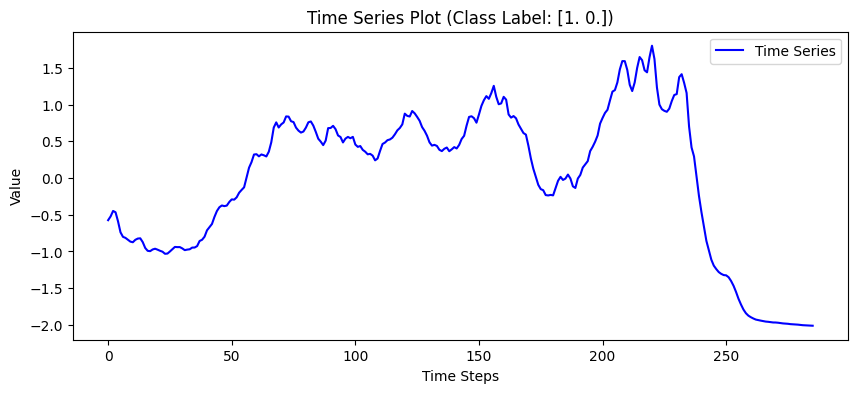

In [ ]:
plot_ts(test_dataset[0])

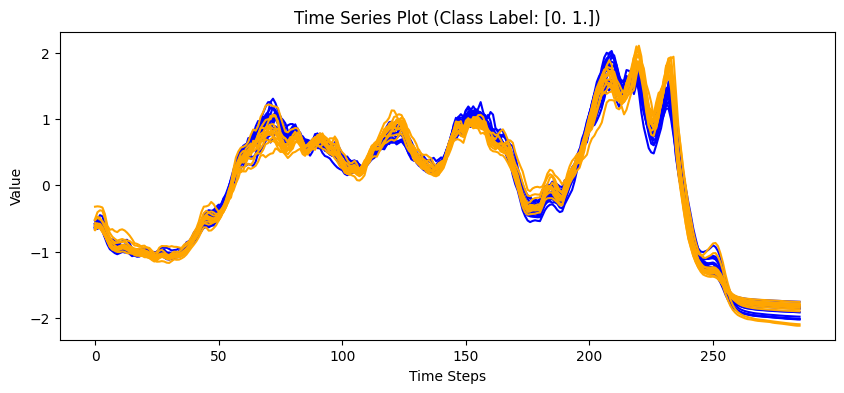

In [118]:
plot_all_ts(test_dataset)